In [1]:
# Para instalar las librerías, solo tiene que ser una vez
if False :
    !pip install PyMuPDF
    !pip install Pillow
    !pip install opencv-python

In [1]:
import os
import numpy as np
import pandas as pd
import re
from matplotlib import pyplot as plt
import fitz # From PyMuPDF
from PIL import Image
import cv2
# import argparse
# import imutils
import sys

In [2]:
def progressBar(value, endvalue, msg='', bar_length=40):
    percent = float(value) / endvalue
    arrow = '-' * int(round(percent * bar_length)-1) + '>'
    spaces = ' ' * (bar_length - len(arrow))

    sys.stdout.write(f"\rProgreso: [{arrow + spaces}] {int(round(percent * 100))}% ({value} de {endvalue} municipios) ({msg} formatos)")
    sys.stdout.flush()

In [3]:
def pdf_to_png(pdf_name, pdf_dir, png_dir, debug=False):
    # Erase ".pdf" in case it is in the name
    pdf_name = pdf_name.replace('.pdf','')
    
    # Open the pdf
    doc = fitz.open(f'{pdf_dir}{pdf_name}.pdf')
    page = doc[0]
    
    # Transform the page into an image
    img = doc.getPageImageList(0)[0]
    xref = img[0]
    pix = fitz.Pixmap(doc, xref)
    
    # Create the png name
    png_name = f'{png_dir}{pdf_name}.png'
    
    # Saves the pdf as a png image
    if pix.n < 5:       # this is GRAY or RGB
        pix.writePNG(png_name)
    else:               # CMYK: convert to RGB first
        pix1 = fitz.Pixmap(fitz.csRGB, pix)
        pix1.writePNG(png_name)
        pix1 = None
    pix = None
    
    if debug:
        print(f'Image {png_name} was saved')
    
    return png_name

In [4]:
def find_bounding_box(img):
    # Transform the morphplogy of the image to end up with only the darker parts
    se = np.ones((7,7), dtype='uint8')
    morph = cv2.morphologyEx(img, cv2.MORPH_CLOSE, se)

    # Transform to gray
    gray = cv2.cvtColor(morph, cv2.COLOR_BGR2GRAY)

    # Apply threshold
    thresh = cv2.threshold(gray, 30, 255, cv2.THRESH_BINARY)[1]

    # Find contours
    contours = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]
    
    # Define the general size of the squares we are looking for
    rect_size = 32*26
    buffer = 200

    # Calculate area of the contours and keep only those between the range desired
    area = [cv2.contourArea(c) for c in contours]

    # Find the position of the chosen contours in the contour list
    area_pos = [i for i, x in enumerate(area) if (rect_size + buffer) > x > (rect_size - buffer)]

    # Width and height of the image
    height, width = img.shape[:2]
    
    # Save coordinates of the whole box we want
    x0 = width
    x1 = 0
    y0 = height
    y1 = 0
    
    center = (width/2, height/2)
    
    # Empty list to save our squares
    rect_list = []

    # Find which of the contours of correct size are closer to the shape we want
    for i,pos in enumerate(area_pos):
        cont = contours[pos]

        # Find the polynomial aproximation of the contours in order to 
        # find which resemble more a rectangle of the size we want
        approx = cv2.approxPolyDP(cont,0.025*cv2.arcLength(cont,True),True)

        # If there are 4 elements in approx, it is a rectangle or square
        if len(approx) == 4:
            (x, y, w, h) = cv2.boundingRect(approx)

            if (1.45 > w/h > 1.01) & (2000 > y > 400):

                rect_list += [(x, y, w, h)]

                # We save the highest and lowest value of the (x,y) coordinates each
                # iteration so we know the overall bounding box of the table.
                x0 = min(x, x0)
                x1 = max(x + w, x1)

                y0 = min(y, y0)
                y1 = max(y + h, y1)

                # Before this we saved the top left corner of the bottom right square
                # so we need to go to the lower right corner of this square to have
                # the correct area.
                if (x == x1) & (y == y1):
                    x1 = x + w
                    y1 = y + h         

                # Find the triangle corners to calculate the rotation angle 
                cx, cy = ((x + w/2),(y + h/2))
                
                if (cx < center[0]) & (cy < center[1]):
                    cor_1 = (x,y)
                    cen_1 = (cx,cy)
                elif (cx > center[0]) & (cy < center[1]):
                    cor_2 = (x,y)
                    cen_2 = (cx,cy)
                elif (cx > center[0]) & (cy > center[1]):
                    cor_3 = (x,y)
                    cen_3 = (cx,cy)
                elif (cx < center[0]) & (cy > center[1]):
                    cor_4 = (x,y)
                    cen_4 = (cx,cy)
    
    if (not "cor_1" in locals()) & (len(rect_list) == 3):
        cor_1 = (cor_4[0], cor_2[1])
        cen_1 = (cen_4[0], cen_2[1])
    if (not "cor_2" in locals()) & (len(rect_list) == 3):
        cor_2 = (cor_3[0], cor_1[1])
        cen_2 = (cen_3[0], cen_1[1])
    if (not "cor_4" in locals()) & (len(rect_list) == 3):
        cor_2 = (cor_1[0], cor_3[1])
        cen_2 = (cen_1[0], cen_3[1])

    if len(rect_list) in [3,4]:
        corner_1 = cor_1

        if cen_1[1] <= cen_2[1]:    
            corner_2 = cor_2
        else:
            corner_2 = cor_4

        return corner_1, corner_2, rect_list
    else:
        return 'Error', len(rect_list)

In [5]:
def rotate_format(img, corner_1, corner_2):
    # Width and height of the image
    height, width = img.shape[:2]
    
    # Find the angle to rotate the image
    np.seterr('ignore')
    # Calculate sides a and b of the trinangle
    a = abs(corner_1[1] - corner_2[1])
    b = abs(corner_2[0] - corner_1[0])
    # Calculate the hipotenuse
    c = np.sqrt(a**2 + b**2)
    # Calculate the angles of the triangle. They give the rotation angle
    A = np.degrees(np.arcsin(a/c))
    B = np.degrees(np.arcsin(b/c))
    
    # If the triangle is wider than it is tall, the rotation must be clockwise
    # if it is taller than it is wide, the rotation must be counterclockwise
    if (a - b) < 0 :
        angle = min(A,30)
    else:
        angle = -min(B,30)

    img_center = tuple(np.array([width, height]) / 2)
    rot_mat = cv2.getRotationMatrix2D(img_center, angle, 1.0)

    # rotation calculates the cos and sin, taking absolutes of those.
    abs_cos = abs(rot_mat[0,0]) 
    abs_sin = abs(rot_mat[0,1])

    # find the new width and height bounds
    bound_w = int(height * abs_sin + width * abs_cos)
    bound_h = int(height * abs_cos + width * abs_sin)

    # subtract old image center (bringing image back to origo) and adding the new image center coordinates
    rot_mat[0, 2] += bound_w/2 - img_center[0]
    rot_mat[1, 2] += bound_h/2 - img_center[1]

    # rotate image with the new bounds and translated rotation matrix

    rot_img = cv2.warpAffine(img, rot_mat,  (bound_w, bound_h), flags=cv2.INTER_LINEAR)
    
    return rot_img, rot_mat

In [6]:
def crop_rotated_img(img, rot_mat, rect_list):
    # Save coordinates of the whole box we want
    nheight, nwidth = img.shape[:2]
    
    nx0 = nwidth
    nx1 = 0
    ny0 = nheight
    ny1 = 0

    for i,x in enumerate(rect_list):
        x_y_array = np.array(x[:2] + (1,))
        trans_x_y = rot_mat.dot(x_y_array)

        nx, ny, nw, nh = (int(np.round(trans_x_y[0])),
                          int(np.round(trans_x_y[1])),
                          x[2], x[3])
        # We save the highest and lowest value of the (x,y) coordinates each
        # iteration so we know the overall bounding box of the table.
        nx0 = min(nx, nx0)
        nx1 = max(nx + nw, nx1)

        ny0 = min(ny, ny0)
        ny1 = max(ny + nh, ny1)

        # Before this we saved the top left corner of the bottom right square
        # so we need to go to the lower right corner of this square to have
        # the correct area.
        if (nx == nx1) & (ny == ny1):
            nx1 = nx + nw
            ny1 = ny + nh
        
    crop_rot_img = img[ny0:ny1,nx0:nx1]
    
    return crop_rot_img

In [7]:
def main(dept, png_dir = 'formularios_e_14/pdf_crop/'):

    dept_dir = f'formularios_e_14/{dept}/'
    
    aspect_df = pd.DataFrame(columns=['file','width','height','aspect', 'n_rect', 'fail'])
    
    mun_dirs = os.listdir(dept_dir)
    
    cont = 0
    print(f'\nDept: {dept}')
    for i_m,mun in enumerate(mun_dirs):
        
        mun_dir = f'{dept_dir}/{mun}/'
        zona_dirs = os.listdir(mun_dir)
        
        #print(f'\nDept: {dept} - Mun: {mun} ({(i_m+1)}/{len(mun_dirs)} mun)')
        
        for i_z,zona in enumerate(zona_dirs):
            
            zona_dir = f'{mun_dir}/{zona}/'
            pdf_list = os.listdir(zona_dir)
            
            for i,x in enumerate(pdf_list):
                
                cont += 1
                progressBar((i_m+1), len(mun_dirs), cont)
                # Read the pdf and turn it into a png image
                png_name = pdf_to_png(x, zona_dir, png_dir)

                # Read the format as a png
                img = cv2.imread(png_name)

                # When the aspect ratio stops being 0.6, we will have 
                bounding_box = find_bounding_box(img)
                
                fail = 0
                if bounding_box[0] == 'Error':
                    fail = 1
                    aspect_df = aspect_df.append({'file': x, 'n_rect': bounding_box[1], 
                                                  'fail': fail},
                                                 ignore_index=True)
                    os.remove(png_name)
                    cv2.imwrite(png_name.replace('/pdf_crop/','/failed/'), img)
                else:
                    corner_1, corner_2, rect_list = bounding_box

                    rot_img, rot_mat = rotate_format(img, corner_1, corner_2)

                    crop_rot_img = crop_rotated_img(rot_img, rot_mat, rect_list)

                    height, width = crop_rot_img.shape[:2]
                    aspect = width / height

                    # With the aspect ratio of the image we know if we have the correct
                    # piece of the images. The information table has on average an aspect
                    # ratio of 0.6
                    cv2.imwrite(png_name, crop_rot_img)
                        
                    aspect_df = aspect_df.append({'file': x, 'width': width, 'height': height,
                                                  'aspect': aspect, 'n_rect': len(rect_list), 
                                                  'fail': fail},
                                                 ignore_index=True)
        
        aspect_df.to_csv(f'formularios_e_14/aspect_{dept}.csv', index=False, sep=';')
    
    return aspect_df

---

### CORRER TODO

In [8]:
#os.chdir(r'D:\Dropbox\Proyectos\python\formatos_elecciones')
os.chdir(r'C:\Users\gd.orbegozo10\Dropbox\Cosas_Programacion\Python\python\formatos_elecciones')

In [11]:
aspect_df = pd.DataFrame(columns=['file','width','height','aspect', 'n_rect', 'fail'])
for d in ['88']:
    aspect_df_temp = main(dept=d)
    aspect_df.append(aspect_df)


Dept: 88
Progreso: [--------------------------->            ] 70% (48 de 69 municipios) (1645 formatos)

UnboundLocalError: local variable 'cor_3' referenced before assignment

In [22]:
aspect_df_temp[aspect_df_temp.fail == 0].sort_values('aspect')

,file,width,height,aspect,n_rect,fail
888,4193417_E14_PRE_X_05_001_010_XX_01_015_X_XXX.pdf,775,1153,0.672160,4,0
2987,8555813_E14_PRE_X_05_028_099_XX_25_005_X_XXX.pdf,776,1154,0.672444,4,0
2690,2800413_E14_PRE_X_05_026_099_XX_55_003_X_XXX.pdf,776,1154,0.672444,4,0
2930,4725212_E14_PRE_X_05_028_099_XX_25_002_X_XXX.pdf,776,1154,0.672444,4,0
2693,3023215_E14_PRE_X_05_026_099_XX_32_006_X_XXX.pdf,776,1154,0.672444,4,0
...,...,...,...,...,...,...
2053,2068613_E14_PRE_X_05_113_099_XX_33_002_X_XXX.pdf,780,1127,0.692103,4,0
2062,4188018_E14_PRE_X_05_113_099_XX_65_003_X_XXX.pdf,781,1127,0.692990,4,0
2067,5611017_E14_PRE_X_05_113_099_XX_21_001_X_XXX.pdf,781,1127,0.692990,4,0
2060,3385016_E14_PRE_X_05_113_099_XX_42_001_X_XXX.pdf,780,1125,0.693333,4,0


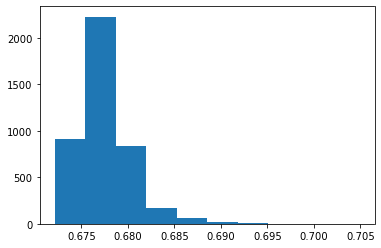

In [17]:
plt.hist(aspect_df_temp.aspect)
plt.show()

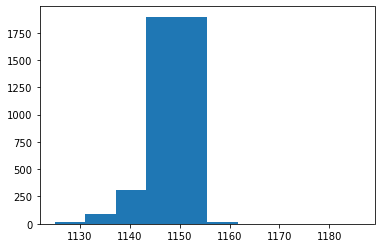

In [18]:
plt.hist(aspect_df_temp.height)
plt.show()

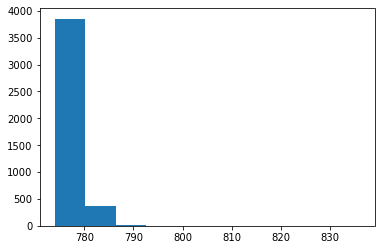

In [20]:
plt.hist(aspect_df_temp.width)
plt.show()

---

In [74]:
dep = '17'
mun = '35'
zona = '00'
x = '5713111_E14_PRE_X_17_035_000_XX_00_001_X_XXX'
#6399510_E14_PRE_X_28_160_000_XX_00_026_X_XXX

pdf_dir = f'formularios_e_14/{dep}/{mun}/{zona}/'

png_name = pdf_to_png(x, pdf_dir, 'test/')

# Read the format as a png
img = cv2.imread(png_name)

# When the aspect ratio stops being 0.6, we will have 
bounding_box = find_bounding_box(img)

fail = 0
if bounding_box[0] == 'Error':
    fail = 1
    aspect_df = aspect_df.append({'file': x, 'n_rect': bounding_box[1], 
                                  'fail': fail},
                                 ignore_index=True)
    os.remove(png_name)
    cv2.imwrite(png_name.replace('/png/','/failed/'), img)
else:
    corner_1, corner_2, rect_list = bounding_box

    rot_img, rot_mat = rotate_format(img, corner_1, corner_2)

    crop_rot_img = crop_rotated_img(rot_img, rot_mat, rect_list)

    height, width = crop_rot_img.shape[:2]
    aspect = width / height

# With the aspect ratio of the image we know if we have the correct
# piece of the images. The information table has on average an aspect
# ratio of 0.6
cv2.imwrite(png_name, crop_rot_img)


True

In [75]:
h,w = crop_rot_img.shape[:2]
h,w

(1140, 778)

In [107]:
corners = [(0,0), (0,w-1), (h-1,0), (h-1,w-1)]
reduce_sign = [(1,1), (1,-1), (-1,1), (-1,-1)]
print(corners)

[(0, 0), (0, 777), (1139, 0), (1139, 777)]


In [108]:
cut_corners = 1
while (cut_corners > 0):
    print(corners)
    cut_corners = 0
    for i,(y,x) in enumerate(corners) :
        sy,sx = reduce_sign[i]
        if crop_rot_img[y:y+1, x:x+1].mean() == 255 :
            cut_corners += 1
            corners[i] = (y+(1*sy),x+(1*sx))

[(0, 0), (0, 777), (1139, 0), (1139, 777)]
[(1, 1), (1, 776), (1138, 1), (1138, 776)]
[(1, 1), (2, 775), (1137, 2), (1137, 775)]
[(1, 1), (2, 775), (1137, 2), (1136, 774)]


In [119]:
y0,x0 = max([y for y,x in corners[:2]]), min([x for y,x in corners[:2]])
y1,x1 = min([y for y,x in corners[2:]]), max([x for y,x in corners[2:]])
(y0,x0,y1,x1)

(2, 1, 1136, 774)

In [113]:
print(corners)

[(1, 1), (2, 775), (1137, 2), (1136, 774)]


In [90]:
crop_rot_img[1134:1135, 0:1]

array([[[255, 255, 255]]], dtype=uint8)

In [86]:

test_corners = crop_rot_img[y0:y1, x0:x1]

print(test_corners.shape)

cv2.imwrite('test/test_corners.png', test_corners)

(1135, 773, 3)


True

---

In [ ]:
dept_values = ['1', '3', '5', '7', '9', '11', '12', '13', '15', '16', '17', '19', '21',
               '23', '24', '25', '26', '27', '28', '29', '31', '40', '44', '46', '48',
               '50', '52', '54', '56', '60', '64', '68', '72', '88']

In [ ]:
png_dir = 'formularios_e_14/pdf_crop/'
dirs_loc = [i for i,x in enumerate(os.listdir('formularios_e_14')) if x in dept_values]
aspect_df = pd.DataFrame(columns=['file','width','height','aspect', 'n_rect', 'fail'])

In [ ]:
cont = 0
for i,pos in enumerate(dirs_loc):
    
    dept = os.listdir('formularios_e_14/')[pos]
    
    dept_dir = f'formularios_e_14/{dept}/'
    
    mun_dirs = os.listdir(dept_dir)
    
    for i_m,mun in enumerate(mun_dirs):
        
        mun_dir = f'{dept_dir}/{mun}/'
        zona_dirs = os.listdir(mun_dir)
        
        print(f'\nDept: {dept} - Mun: {mun} ({(i_m+1)}/{len(mun_dirs)} mun)')
        
        for i_z,zona in enumerate(zona_dirs):
            
            zona_dir = f'{mun_dir}/{zona}/'
            pdf_list = os.listdir(zona_dir)
            
            for i,x in enumerate(pdf_list):
                
                cont += 1
                progressBar((i_z+1), len(zona_dirs), cont)
                # Read the pdf and turn it into a png image
                png_name = pdf_to_png(x, zona_dir, png_dir)

                # Read the format as a png
                img = cv2.imread(png_name)

                # When the aspect ratio stops being 0.6, we will have 
                bounding_box = find_bounding_box(img)
                
                fail = 0
                if bounding_box[0] == 'Error':
                    fail = 1
                    aspect_df = aspect_df.append({'file': x, 'n_rect': bounding_box[1], 
                                                  'fail': fail},
                                                 ignore_index=True)
                    os.remove(png_name)
                    cv2.imwrite(png_name.replace('/png/','/failed/'), img)
                else:
                    corner_1, corner_2, rect_list = bounding_box

                    rot_img, rot_mat = rotate_format(img, corner_1, corner_2)

                    crop_rot_img = crop_rotated_img(rot_img, rot_mat, rect_list)

                    height, width = crop_rot_img.shape[:2]
                    aspect = width / height

                    # With the aspect ratio of the image we know if we have the correct
                    # piece of the images. The information table has on average an aspect
                    # ratio of 0.6
                    cv2.imwrite(png_name, crop_rot_img)
                        
                    aspect_df = aspect_df.append({'file': x, 'width': width, 'height': height,
                                                  'aspect': aspect, 'n_rect': len(rect_list), 
                                                  'fail': fail},
                                                 ignore_index=True)

In [ ]:
for i,x in enumerate(aspect_df[aspect_df.fail == 1].file):
    os.remove(f'formularios_e_14/png/{x}'.replace('.pdf','.png'))

In [ ]:
aspect_df[aspect_df.fail == 0].sort_values('aspect')

In [ ]:
plt.hist(aspect_df.aspect)
plt.show()

In [ ]:
plt.hist(aspect_df.height)
plt.show()

In [ ]:
plt.hist(aspect_df.width)
plt.show()

In [ ]:
aspect_df[aspect_df.fail==1]

In [ ]:
test = img

# Transform the morphplogy of the image to end up with only the darker parts
se = np.ones((7,7), dtype='uint8')
morph = cv2.morphologyEx(img, cv2.MORPH_CLOSE, se)

# Transform to gray
gray = cv2.cvtColor(morph, cv2.COLOR_BGR2GRAY)

# Apply threshold
thresh = cv2.threshold(gray, 30, 255, cv2.THRESH_BINARY)[1]

# Find contours
contours = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = contours[0] if len(contours) == 2 else contours[1]

# Define the general size of the squares we are looking for
rect_size = 32*26
buffer = 200

# Calculate area of the contours and keep only those between the range desired
area = [cv2.contourArea(c) for c in contours]

# Find the position of the chosen contours in the contour list
area_pos = [i for i, x in enumerate(area) if (rect_size + buffer) > x > (rect_size - buffer)]

# Width and height of the image
height, width = img.shape[:2]

# Save coordinates of the whole box we want
x0 = width
x1 = 0
y0 = height
y1 = 0

center = (width/2, height/2)

# Empty list to save our squares
rect_list = []

# Find which of the contours of correct size are closer to the shape we want
for i,pos in enumerate(area_pos):
    cont = contours[pos]

    # Find the polynomial aproximation of the contours in order to 
    # find which resemble more a rectangle of the size we want
    approx = cv2.approxPolyDP(cont,0.025*cv2.arcLength(cont,True),True)

    # If there are 4 elements in approx, it is a rectangle or square
    print(len(approx))
    if len(approx) == 4:
        (x, y, w, h) = cv2.boundingRect(approx)
        print(w/h)

        if (1.4 > w/h > 0.7) & (2000 > y > 400):

            rect_list += [(x, y, w, h)]

            # We save the highest and lowest value of the (x,y) coordinates each
            # iteration so we know the overall bounding box of the table.
            x0 = min(x, x0)
            x1 = max(x + w, x1)

            y0 = min(y, y0)
            y1 = max(y + h, y1)

            # Before this we saved the top left corner of the bottom right square
            # so we need to go to the lower right corner of this square to have
            # the correct area.
            if (x == x1) & (y == y1):
                x1 = x + w
                y1 = y + h         

            # Find the triangle corners to calculate the rotation angle 
            cx, cy = ((x + w/2),(y + h/2))

            if (cx < center[0]) & (cy < center[1]):
                cor_1 = (x,y)
                cen_1 = (cx,cy)
            elif (cx > center[0]) & (cy < center[1]):
                cor_2 = (x,y)
                cen_2 = (cx,cy)
            elif (cx > center[0]) & (cy > center[1]):
                cor_3 = (x,y)
                cen_3 = (cx,cy)
            elif (cx < center[0]) & (cy > center[1]):
                cor_4 = (x,y)
                cen_4 = (cx,cy)

corner_1 = cor_1

if cen_1[1] <= cen_2[1]:    
    corner_2 = cor_2
else:
    corner_2 = cor_4


---

In [ ]:
os.chdir(r'D:\Dropbox\Proyectos\python\formatos_elecciones')
pdf_dir = 'formularios_e_14/pdf_no_text/'
png_dir = 'formularios_e_14/png_no_text/'
pdf_list = [x for i,x in enumerate(os.listdir(pdf_dir)) if '.pdf' in x]
aspect_df = pd.DataFrame(columns=['file','width','height','aspect', 'n_rect', 'fail'])

In [ ]:
for i,x in enumerate(pdf_list):

    # Read the pdf and turn it into a png image
    png_name = pdf_to_png(x, pdf_dir, png_dir)
    
    # Read the format as a png
    img = cv2.imread(png_name)

    # When the aspect ratio stops being 0.6, we will have 
    corner_1, corner_2, rect_list = find_bounding_box(img)

    rot_img, rot_mat = rotate_format(img, corner_1, corner_2)

    crop_rot_img = crop_rotated_img(rot_img, rot_mat, rect_list)

    height, width = crop_rot_img.shape[:2]
    aspect = width / height

    # With the aspect ratio of the image we know if we have the correct
    # piece of the images. The information table has on average an aspect
    # ratio of 0.6
    fail = 0

    if aspect < 0.6:
        fail = 1
        png_name_f = f'formularios_e_14/failed/{x.replace("pdf","png")}'
        progressBar((i+1),len(pdf_list))    
        cv2.imwrite(png_name_f, crop_rot_img)
    else:
        progressBar((i+1),len(pdf_list))    
        cv2.imwrite(png_name, crop_rot_img)
    
    aspect_df = aspect_df.append({'file': x, 'width': width, 'height': height,
                                    'aspect': aspect, 'n_rect': len(rect_list), 'fail': fail},
                                   ignore_index=True)


In [ ]:
plt.hist(aspect_df.height)
plt.show()

In [ ]:
plt.hist(aspect_df.width)
plt.show()

In [ ]:
plt.hist(aspect_df.aspect)
plt.show()

In [ ]:
aspect_df.sort_values('aspect')

---

In [ ]:
os.chdir(r'D:\Dropbox\Proyectos\python\formatos_elecciones')
pdf_dir = 'formularios_e_14/pdf_no_text/'
png_dir = 'formularios_e_14/png_no_text/'
pdf_list = [x for i,x in enumerate(os.listdir(pdf_dir)) if '.pdf' in x]
aspect_df = pd.DataFrame(columns=['file','width','height','aspect'])

In [ ]:
for i,x in enumerate(['8780814_E14_PRE_X_28_001_005_XX_01_018_X_XXX.pdf']):
    
    # Read the pdf and turn it into a png image
    png_name = pdf_to_png(x, pdf_dir, png_dir)
    
    # Read the format as a png
    img = cv2.imread(png_name)
    
    # With the aspect ratio of the image we know if we have the correct
    # piece of the images. The information table has on average an aspect
    # ratio of 0.6

    # When the aspect ratio stops being 0.6, we will have 
    corner_1, corner_2, rect_list = find_bounding_box(img)

    rot_img, rot_mat = rotate_format(img, corner_1, corner_2)

    crop_rot_img = crop_rotated_img(rot_img, rot_mat, rect_list)

    height, width = crop_rot_img.shape[:2]
    aspect = width / height

    if aspect < 0.6:
        raise Warning(x)

    aspect_df = aspect_df.append({'file': x, 'width': width, 'height': height, 
                                  'aspect': aspect}, 
                                  ignore_index=True)

    progressBar((i+1),len(pdf_list))    
    cv2.imwrite(png_name, crop_rot_img)

In [ ]:
rect_list

In [ ]:
aspect_df.sort_values('aspect')

---

In [13]:
os.chdir(r'D:\Dropbox\Proyectos\python\formatos_elecciones')
#os.chdir(r'C:\Users\gd.orbegozo10\Dropbox\Cosas_Programacion\Python\python\formatos_elecciones')

In [34]:
aspect_df = pd.DataFrame(columns=['file','width','height','aspect', 'n_rect', 'fail'])
for d in ['1']:
    aspect_df_temp = main(dept=d)
    aspect_df.append(aspect_df)


Dept: 1
Progreso: [>                                       ] 1% (1 de 125 municipios) (28 formatos)

KeyboardInterrupt: 